<a href="https://colab.research.google.com/github/jedhouas/Advanced-Deep-Learning/blob/master/TP2_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.

* **To be submitted by next session**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [0]:
!wget https://www.lri.fr/~gcharpia/deeppractice/2020/TP2/TP2_images.zip

--2020-02-08 14:23:24--  https://www.lri.fr/~gcharpia/deeppractice/2020/TP2/TP2_images.zip
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477062 (1.4M) [application/zip]
Saving to: ‘TP2_images.zip’

TP2_images.zip      100%[===================>]   1.41M  1.49MB/s    in 0.9s    

2020-02-08 14:23:25 (1.49 MB/s) - ‘TP2_images.zip’ saved [1477062/1477062]



In [0]:
!mkdir data

In [0]:
!unzip TP2_images.zip -d data/TP2_images

Archive:  TP2_images.zip
   creating: data/TP2_images/.ipynb_checkpoints/
  inflating: data/TP2_images/155881293_721e90b57d.jpg  
  inflating: data/TP2_images/158850087_3251644046.jpg  
  inflating: data/TP2_images/1624593475_146bf1f7ff.jpg  
  inflating: data/TP2_images/181748579_01a4611736.jpg  
  inflating: data/TP2_images/2068921624_ef0986de13.jpg  
  inflating: data/TP2_images/2637374064_fab14ec0b8.jpg  
  inflating: data/TP2_images/2749465889_8e62023674.jpg  
  inflating: data/TP2_images/2936812850_23bf0d1cfd.jpg  
  inflating: data/TP2_images/3532471222_a6d7e3780e.jpg  
  inflating: data/TP2_images/3633913271_ee789a3bc4.jpg  
  inflating: data/TP2_images/3633949157_f577605ea9.jpg  
  inflating: data/TP2_images/3894967408_706f2135c6.jpg  
  inflating: data/TP2_images/4020994958_ee0f171e0d.jpg  
  inflating: data/TP2_images/4178031069_53cc807d15.jpg  
  inflating: data/TP2_images/430941039_63cdefff92.jpg  
  inflating: data/TP2_images/481635090_85a1c668ed.jpg  
  inflating: data/T

In [0]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils import data
import seaborn as sns 
import cv2
%matplotlib inline

### Download the Model
We provide you a pretrained model `VGG-16` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **VGG-16**: A deep architecture for image classification.

![vgg_16.png](https://www.researchgate.net/profile/Bibo_Shi/publication/323440752/figure/fig1/AS:739814685032448@1553396974148/The-architecture-of-VGG-16-model-To-represent-different-depth-levels-convolutional.jpg)

In [0]:
# The downloading process may take a few minutes. 
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course; notice that the images should be placed in a **sub**-directory of the path indicated below).<br>
In order to use the pretrained model vgg-16, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [0]:
# Define preprocessing function of the input images
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [0]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them
dir_path = "data/" 
dataset = preprocess_image(dir_path)

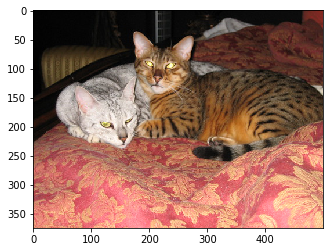

In [0]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

Predict the label of the input image, and print the top-3 possible classes

In [0]:
output = vgg_model(dataset[index][0].view(1, 3, 224, 224))

values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy())
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282]
Raw class scores: [20.475704 20.30595  19.468111]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model vgg-16 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. Run `print(vgg_model)` to get more information on VGG model.
 + The size of feature maps is 14x14, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

![Grad_CAM](https://upload-images.jianshu.io/upload_images/415974-0147c44dcfb8cc1c.jpg)

In [0]:
class VGG16(nn.Module):
    def __init__(self,vgg):
        super(VGG16, self).__init__()
        self.vgg = vgg
        self.gradient_in = None
        self.gradient_out = None
        self.h=None
    # hook for the gradients of the activations
    def hook_grad(self,module,grad_input, grad_output):
        self.gradient_in = grad_input
        self.gradient_out = grad_output
    def hook(self):
      self.h=self.vgg.features[-2].register_backward_hook(self.hook_grad)
    def remove_hook(self):
      self.h.remove()
    def forward(self, x):
        return self.vgg(x)

In [0]:
original_dataset=datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224)] # resize the image to 224x224
            ))

In [0]:
net=VGG16(vgg_model)
net.hook()
net.eval()

VGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

In [0]:
input_image=np.random.randint(20)
image,label=dataset.__getitem__(input_image)
image=image.unsqueeze(0)
pred=net(image)
idx=pred.argmax()
pred[:,idx].backward()
gradients=net.gradient_out[0]

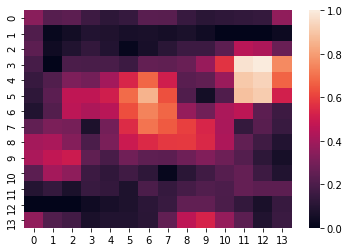

In [0]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
# get the activations of the last convolutional layer
activations = net.vgg.features[:-1](image).detach()
# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
# relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)
# normalize the heatmap
heatmap /= torch.max(heatmap)
#Turn to a numpy array 
heatmap=heatmap.numpy()
# draw the heatmap
sns.heatmap(heatmap.squeeze())

In [0]:
img=np.array(original_dataset.__getitem__(input_image)[0])
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = np.uint8(heatmap_resized * 0.5 + img)

Text(0.5, 1.0, 'Both ')

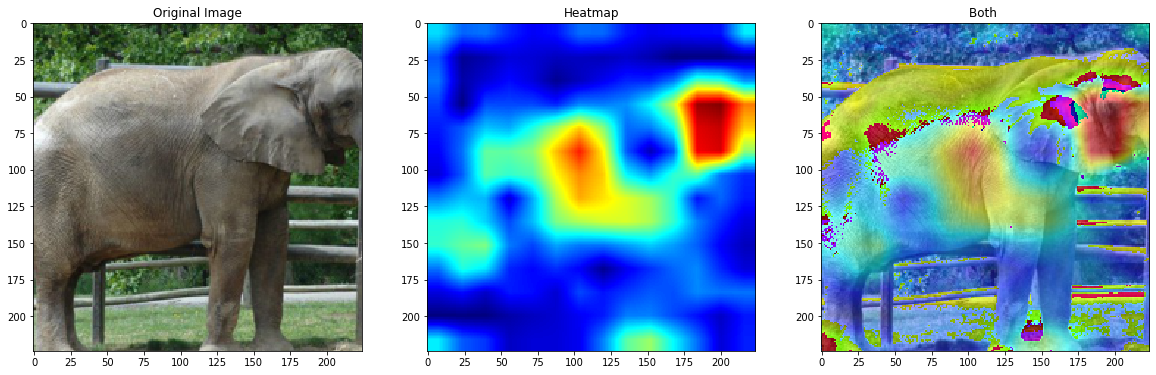

In [0]:
figure,axes=plt.subplots(1,3,figsize=(20,20))
axes[0].imshow(np.array(img))
axes[0].set_title('Original Image')
axes[1].imshow(cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB))
axes[1].set_title('Heatmap')
axes[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axes[2].set_title('Both ')
